In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os; os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [33]:
import numpy as np
import tensorflow as tf
from fastcore.xtras import Path

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import scipy.stats as stats

from perceptnet.networks import *
from iqadatasets.datasets.tid2013 import TID2013

from flayers.callbacks import *

In [34]:
class EvaluatePerceptuality(tf.keras.callbacks.Callback):
    """Evaluates a perceptual model that is part of another model."""

    def __init__(self, 
                 dst, # Dataset to be evaluated.
                 model, # Model to be evaluated.
                 name=None, # Name to prepend to the logged metrics.
                 ):
        self.dst = dst
        self.eval_model = model
        self.name = "" if name is None else name+"_"
        
    def on_epoch_end(self,
                     epoch, 
                     logs=None):
        distances, moses = [], []
        for i, data in enumerate(self.dst):
            img, dist_img, mos = data
            features_original = self.eval_model(img, training=False)
            features_distorted = self.eval_model(dist_img, training=False)
            l2 = (features_original-features_distorted)**2
            l2 = tf.reduce_sum(l2, axis=[1,2,3])
            l2 = tf.sqrt(l2)
            distances.extend(l2)
            moses.extend(mos)
        pearson = stats.pearsonr(distances, moses)[0]
        spearman = stats.spearmanr(distances, moses)[0]
        wandb.log({f"{self.name}Pearson": pearson,
                   f"{self.name}Spearman": spearman}, commit=False)

# Wandb config

In [35]:
# id = "7cakiknt" # imagenet
# id = "psmk04za" # cifar10
# id = "0cnhyn1v" # cifar100
id = "iupl77hz" # imagenette
# MORE_EPOCHS = 500
MORE_EPOCHS = 0

In [36]:
wandb.init(project='PerceptNetClassification',
            id=id,
            mode="online",
            resume="allow",
            )
config = wandb.config
# config.epochs += MORE_EPOCHS
config

wandb: Currently logged in as: jorgvt. Use `wandb login --relogin` to force relogin


{'seed': 42, 'epochs': 1500, 'dataset': 'imagenette', 'verbose': 0, 'batch_size': 64, 'learning_rate': 0.0003, 'gdn_kernel_size': 1, 'validation_split': 0.2, 'kernel_initializer': 'ones', 'learnable_undersampling': False}

In [7]:
api = wandb.Api()
run = api.run(f"jorgvt/PerceptNetClassification/{id}")

In [18]:
df = run.history()
df.sort_values(by="epoch/epoch", inplace=True)

In [15]:
import matplotlib.pyplot as plt

263
0.6018000245094299


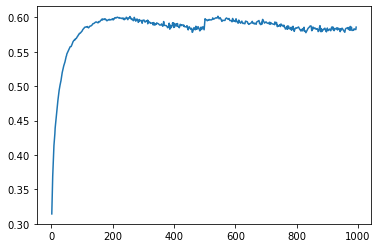

In [24]:
plt.plot(df["epoch/epoch"], df["epoch/val_accuracy"])
print(df["epoch/val_accuracy"].argmax())
print(df["epoch/val_accuracy"].max())
plt.show()

In [28]:
list(run.logged_artifacts())[0].name

'run_psmk04za_model:v0'

In [33]:
artifact = api.artifact(f'PerceptNetClassification/run_{id}_model:v{df["epoch/val_accuracy"].argmax()}')
path = artifact.download()

wandb:   3 of 3 files downloaded.  


In [34]:
path

'./artifacts/run_psmk04za_model:v263'

In [41]:
config = run.config
config

{'seed': 42,
 'epochs': 1000,
 'dataset': 'cifar10',
 'verbose': 0,
 'batch_size': 64,
 'learning_rate': 0.0003,
 'gdn_kernel_size': 1,
 'validation_split': 0.2,
 'kernel_initializer': 'ones',
 'learnable_undersampling': False}

# Load the data

In [37]:
def load_imagenet():
    path_data = Path("/lustre/ific.uv.es/ml/uv075/Databases/imagenet_images/")
    dst_train = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="training",
                seed=config.seed,
                shuffle=True,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    dst_val = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="validation",
                seed=config.seed,
                shuffle=False,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    return dst_train, dst_val

In [38]:
def load_imagenette():
    import tensorflow_datasets as tfds

    dst_train, info = tfds.load("imagenette/320px-v2", split=f"train[:{config.validation_split*100:.0f}%]", with_info=True, shuffle_files=True)
    dst_val = tfds.load("imagenette/320px-v2", split=f"train[{config.validation_split*100:.0f}%:]", with_info=False, shuffle_files=False)
    def prepare_tfds(item):
        x, y = item["image"], item["label"]
        x = tf.image.resize_with_crop_or_pad(x, 256, 256)
        return x, y
    dst_train = dst_train.map(prepare_tfds)
    dst_val = dst_val.map(prepare_tfds)

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size), info.features["label"].num_classes

In [39]:
def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config["validation_split"], random_state=config["seed"])
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config["batch_size"]), dst_val.batch(config["batch_size"])

In [40]:
def load_cifar100():
    from tensorflow.keras.datasets import cifar100
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar100.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.seed)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size)

In [41]:
if config.dataset == "imagenet":
    dst_train, dst_val = load_imagenet()
    N_CLASSES = len(dst_train.class_names)
elif config.dataset == "cifar10":
    dst_train, dst_val = load_cifar10()
    N_CLASSES = 10
elif config.dataset == "cifar100":
    dst_train, dst_val = load_cifar100()
    N_CLASSES = 100
elif config.dataset == "imagenette":
    dst_train, dst_val, N_CLASSES = load_imagenette()
else:
    raise ValueError("Dataset parameter not allowed.")
print(f"Training on {config.dataset} with {N_CLASSES} classes.")

Training on imagenette with 10 classes.


In [42]:
x, y = next(iter(dst_train))
input_shape = x[0].shape
input_shape

TensorShape([256, 256, 3])

In [43]:
dst_tid2013 = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013", exclude_imgs=[25]).dataset.batch(config.batch_size)

### Normalize the data

In [44]:
normalization_layer = layers.Rescaling(1./255)

In [45]:
dst_train = dst_train.map(lambda x,y: (normalization_layer(x), y))
dst_val = dst_val.map(lambda x,y: (normalization_layer(x), y))

In [46]:
x, y = next(iter(dst_train))
input_shape = x[0].shape
input_shape, tf.reduce_max(x), tf.reduce_min(x)

(TensorShape([256, 256, 3]),
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

### Performance

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

dst_train = dst_train.cache().prefetch(buffer_size=AUTOTUNE)
dst_val = dst_val.cache().prefetch(buffer_size=AUTOTUNE)

# Define the model

In [48]:
feature_extractor = PerceptNet(kernel_initializer=config["kernel_initializer"], gdn_kernel_size=config["gdn_kernel_size"], learnable_undersampling=config["learnable_undersampling"])
model = tf.keras.Sequential([
    feature_extractor,
    layers.GlobalAveragePooling2D(),
    layers.Dense(N_CLASSES, activation="softmax")
])

In [49]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=config["learning_rate"]),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [50]:
if config.dataset == "imagenet" or config.dataset == "imagenette":
    model.build((None,256,256,3))
elif config.dataset == "cifar10" or config.dataset == "cifar100":
    model.build((None,32,32,3))
else: # If it isn't a known dataset, just call the model on a batch of data to build the weights.
    pred = model(x)

In [51]:
best_model = wandb.run.use_artifact(f"run_{wandb.run.id}_model:latest", type="model")
best_model_dir = best_model.download()

wandb:   3 of 3 files downloaded.  


In [52]:
model.weights[0]

<tf.Variable 'percept_net_1/gdn_4/kernel:0' shape=(1, 1, 1, 3) dtype=float32, numpy=array([[[[1., 1., 1.]]]], dtype=float32)>

In [53]:
model.load_weights(f"{best_model_dir}/model-best")

In [54]:
model.weights[0]

<tf.Variable 'percept_net_1/gdn_4/kernel:0' shape=(1, 1, 1, 3) dtype=float32, numpy=array([[[[0.33880746, 0.9243364 , 0.47865188]]]], dtype=float32)>

In [55]:
model.evaluate(dst_train)

30/30 [==============================] - 6s 186ms/step - loss: 0.7042 - accuracy: 0.7730


[0.7041791677474976, 0.7729672789573669]

In [25]:
summary = wandb.run.summary._as_dict()
summary["epoch/epoch"], summary["_step"]

(499, 499)

In [22]:
history = model.fit(dst_train, 
                    epochs=config.epochs, 
                    initial_epoch=summary["epoch/epoch"]+1,
                    validation_data=dst_val,
                    callbacks=[EvaluatePerceptuality(dst=dst_tid2013, model=feature_extractor, name="TID2013"),
                               WandbMetricsLogger(log_freq="epoch", initial_global_step=summary["_step"]+1),
                               WandbModelCheckpoint(filepath="model-best",
                                                    monitor="val_loss",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode="min")
                               ],
                    verbose=config.verbose)

2023-03-05 12:48:28.836862: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-05 12:48:31.860608: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [56]:
wandb.finish()

N_CLASSES,10
TID2013_Pearson,-0.55598
TID2013_Spearman,-0.59613
epoch/accuracy,0.78775
epoch/epoch,1499
epoch/learning_rate,0.0003
epoch/loss,0.66256
epoch/val_accuracy,0.6404
epoch/val_loss,1.17904
parameters,37666
trainable_parameters,37658
